### Imports

In [24]:
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pydot
import seaborn as sns
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.seasonal import STL
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay

In [27]:
df = pd.read_csv('ready_data.csv')
datetime = pd.to_datetime(df.pop('DatetimeBegin'), format='%Y.%m.%d %H:%M:%S')
df.drop(columns=['SO2 Concentration', 'C6H6 Concentration'], inplace=True)
df

,PM10 Concentration,PM2.5 Concentration,CO Concentration,NO2 Concentration
0,38.942000,39.314600,0.461680,21.605600
1,52.889000,39.314600,0.432680,21.186900
2,37.007000,37.668000,0.392080,16.284500
3,35.837000,37.333000,0.386280,17.324600
4,34.408000,29.130000,0.363080,15.565600
...,...,...,...,...
26300,20.642903,13.122164,0.361663,29.192009
26301,21.812805,14.244807,0.383440,30.921196
26302,21.234059,13.375752,0.361133,29.743226
26303,22.205407,14.307335,0.379205,31.180601


### Scaling

In [19]:
scaler = MinMaxScaler()
df_original = df.copy()
df = scaler.fit_transform(df)

### Dataset batching

In [20]:
trainX = []
trainY = []

look_back = 24
future_n = 1

for i in range(look_back, len(df) - future_n + 1):
    trainX.append(df[i - look_back: i, 0: df.shape[1]])
    trainY.append(df[i + future_n - 1: i + future_n, 0]) # PM10 je zvoleny ako y label

trainX = np.array(trainX)
trainY = np.array(trainY)
print(f'x shape: {trainX.shape}; y shape: {trainY.shape}')

x shape: (26281, 24, 4); y shape: (26281, 1)


### Model creation & training

In [58]:
model = tf.keras.Sequential([
    LSTM(units=60, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True),
    LSTM(units=32, activation='relu', return_sequences=False),
    Dropout(0.2),
    Dense(units=1)
])

model.compile(
    loss=tf.keras.losses.MeanSquaredError(),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=[tf.keras.metrics.MeanAbsoluteError(),
        tf.keras.metrics.RootMeanSquaredError(),
        tf.keras.metrics.MeanAbsolutePercentageError()
    ]
)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 24, 60)            15600     
                                                                 
 lstm_3 (LSTM)               (None, 32)                11904     
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 27,537
Trainable params: 27,537
Non-trainable params: 0
_________________________________________________________________


In [59]:
history = model.fit(trainX, trainY, epochs=10, batch_size=16, validation_split=0.1)

Epoch 1/10
1479/1479 [==============================] - 17s 10ms/step - loss: 0.0183 - mean_absolute_error: 0.0966 - root_mean_squared_error: 0.1353 - mean_absolute_percentage_error: 2049.9346 - val_loss: 0.0054 - val_mean_absolute_error: 0.0522 - val_root_mean_squared_error: 0.0737 - val_mean_absolute_percentage_error: 29.3748
Epoch 2/10
1479/1479 [==============================] - 15s 10ms/step - loss: 0.0092 - mean_absolute_error: 0.0693 - root_mean_squared_error: 0.0958 - mean_absolute_percentage_error: 2080.4236 - val_loss: 0.0055 - val_mean_absolute_error: 0.0519 - val_root_mean_squared_error: 0.0740 - val_mean_absolute_percentage_error: 24.2259
Epoch 3/10
1479/1479 [==============================] - 15s 10ms/step - loss: 0.0082 - mean_absolute_error: 0.0656 - root_mean_squared_error: 0.0908 - mean_absolute_percentage_error: 4299.4780 - val_loss: 0.0055 - val_mean_absolute_error: 0.0523 - val_root_mean_squared_error: 0.0743 - val_mean_absolute_percentage_error: 23.1585
Epoch 4/10

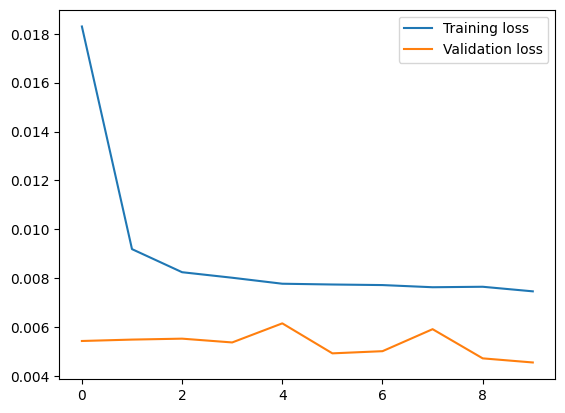

In [60]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

### Predictions

In [63]:
hours_to_predict = 24
past_hours = 24*10

y_pred = model.predict(trainX[-past_hours:])
print(y_pred.shape)
y_pred

8/8 [==============================] - 0s 4ms/step
(240, 1)


array([[ 0.28091696],
       [ 0.304843  ],
       [ 0.25508818],
       [ 0.24841091],
       [ 0.25019437],
       [ 0.2813007 ],
       [ 0.27040428],
       [ 0.27043378],
       [ 0.2553903 ],
       [ 0.23104715],
       [ 0.1533513 ],
       [ 0.24851939],
       [ 0.21889985],
       [ 0.21818024],
       [ 0.29465833],
       [ 0.28158295],
       [ 0.28388095],
       [ 0.28415093],
       [ 0.20390625],
       [ 0.25656015],
       [ 0.30642048],
       [ 0.4327621 ],
       [ 0.5861184 ],
       [ 0.61509085],
       [ 0.44559026],
       [ 0.20982555],
       [ 0.2003326 ],
       [ 0.20301309],
       [ 0.20759793],
       [ 0.18217126],
       [ 0.17469786],
       [ 0.16907457],
       [ 0.0907436 ],
       [ 0.07663912],
       [ 0.11703569],
       [ 0.11373883],
       [ 0.14912194],
       [ 0.20770712],
       [ 0.21395858],
       [ 0.14675248],
       [ 0.14442736],
       [ 0.12773272],
       [ 0.15349796],
       [ 0.09804663],
       [ 0.11679649],
       [ 0

### Inverse scaling

In [64]:
y_pred = np.repeat(y_pred, df.shape[1], axis=-1)
y_pred = scaler.inverse_transform(y_pred)[:,0]

In [71]:
real_data = df_original['PM10 Concentration'].to_numpy()[-240:]

In [69]:
y_pred

array([15.090481 , 16.375534 , 13.703233 , 13.344602 , 13.440389 ,
       15.111091 , 14.525851 , 14.527435 , 13.719459 , 12.412004 ,
        8.239007 , 13.350428 , 11.75958  , 11.72093  , 15.828522 ,
       15.126251 , 15.249675 , 15.264175 , 10.954283 , 13.782291 ,
       16.460258 , 23.24599  , 31.482668 , 33.03876  , 23.934984 ,
       11.272204 , 10.762343 , 10.906312 , 11.15256  ,  9.786909 ,
        9.385517 ,  9.083494 ,  4.8763843,  4.1188407,  6.2885165,
        6.1114445,  8.01185  , 11.158425 , 11.494187 ,  7.884588 ,
        7.759707 ,  6.863048 ,  8.246883 ,  5.2686257,  6.2756696,
        4.1923914,  3.0150592,  2.007902 ,  3.366858 ,  2.608641 ,
        3.9087296,  5.3883104,  5.4063644,  5.5166454,  6.2754164,
        8.772714 ,  9.8928175,  9.909556 ,  9.222241 , 10.180732 ,
       15.20977  , 17.448334 , 19.86391  , 22.185205 , 24.880535 ,
       24.396488 , 22.138754 , 17.231781 , 13.855889 , 14.863127 ,
       15.629749 , 17.80977  , 19.36936  , 21.20689  , 18.5775

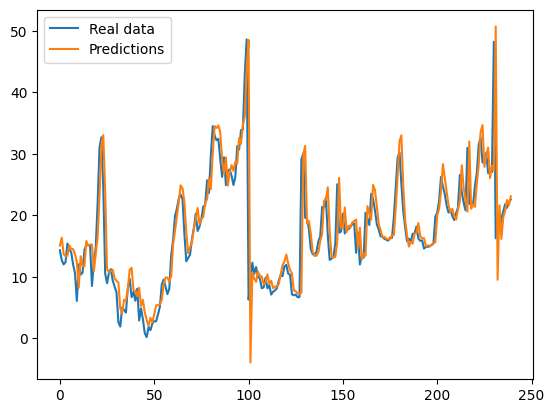

In [74]:
plt.plot(real_data)
plt.plot(y_pred)
plt.legend(['Real data', 'Predictions'])
plt.show()